# Ensemble: pr/prra/prsn (over sea-ice)

## Imports & defaults

In [1]:
import libs.ensemble
import libs.local
import libs.plot
import libs.vars
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

matplotlib.rcParams.update({ 'font.size': 18 })

/home/users/woodward/.conda/envs/climate/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Data

In [2]:
# ----- SPECIFIC SETTINGS -----
component = 'Amon'
experiment = 'ssp585'
variable_id = 'prra_siconc'

conf = [v for v in libs.vars.variables() if v['variable_id'] == variable_id][0]
time_series_text = '''total precipitation (solid), rainfall (dashed),\nand snowfall (dashdot) over sea-ice'''
time_series_weighted_method = conf['weighting_method']
time_series_units = conf['units']
time_series_y_label = f'Precipitation ({time_series_units})'
time_series_y_range = (0, 1.75)
time_series_y_range_monthly = (0, 2)
time_series_y_range_regional = (0, 4)
time_series_process = lambda x: x

In [3]:
ensemble_prra_time_series = time_series_process(
    libs.local.get_ensemble_series(variable_id, experiment)
)
ensemble_prra_time_series_smooth = time_series_process(
    libs.local.get_ensemble_series(variable_id, experiment, suffix='_smooth')
).fillna(0)
for variable in ensemble_prra_time_series:
    ensemble_prra_time_series[variable].attrs['plot_kwargs'] = { 'linestyle': 'dashed' }
    ensemble_prra_time_series_smooth[variable].attrs['plot_kwargs'] = { 'linestyle': 'dashed' }


ensemble_pr_time_series = time_series_process(
    libs.local.get_ensemble_series('pr_siconc', experiment)
)
ensemble_pr_time_series_smooth = time_series_process(
    libs.local.get_ensemble_series('pr_siconc', experiment, suffix='_smooth')
).fillna(0)


ensemble_prsn_time_series = time_series_process(
    libs.local.get_ensemble_series('prsn_siconc', experiment)
)
ensemble_prsn_time_series_smooth = time_series_process(
    libs.local.get_ensemble_series('prsn_siconc', experiment, suffix='_smooth')
).fillna(0)
for variable in ensemble_prsn_time_series:
    ensemble_prsn_time_series[variable].attrs['plot_kwargs'] = { 'linestyle': 'dashdot' }
    ensemble_prsn_time_series_smooth[variable].attrs['plot_kwargs'] = { 'linestyle': 'dashdot' }


ensemble_tas_time_series = libs.local.get_ensemble_series('tas_siconc', experiment)
ensemble_tas_time_series_smooth = libs.local.get_ensemble_series('tas_siconc', experiment, suffix='_smooth')

ensemble_tas_time_series /= 10
ensemble_tas_time_series_smooth /= 10

for variable in ensemble_tas_time_series:
    ensemble_tas_time_series[variable].attrs['plot_kwargs'] = { 'linestyle': 'dashdot' }
    ensemble_tas_time_series_smooth[variable].attrs['plot_kwargs'] = { 'linestyle': 'dashdot' }
    

ensemble_siconc_time_series = time_series_process(
    libs.local.get_ensemble_series('siconc', experiment)
)
ensemble_siconc_time_series /= 1e7
ensemble_siconc_time_series_smooth = time_series_process(
    libs.local.get_ensemble_series('siconc', experiment, suffix='_smooth')
)

for variable in ensemble_siconc_time_series:
    ensemble_siconc_time_series[variable].attrs['plot_kwargs'] = { 'linestyle': 'dotted' }


ensemble_sithick_time_series = time_series_process(
    libs.local.get_ensemble_series('sithick', experiment)
)

ensemble_sisnthick_time_series = time_series_process(
    libs.local.get_ensemble_series('sisnthick', experiment)
)
ensemble_sisnthick_time_series *= 10

ensemble_simass_time_series = time_series_process(
    libs.local.get_ensemble_series('simass', experiment)
)

time_slices = libs.vars.default_time_slices()

## Time series

### Mean

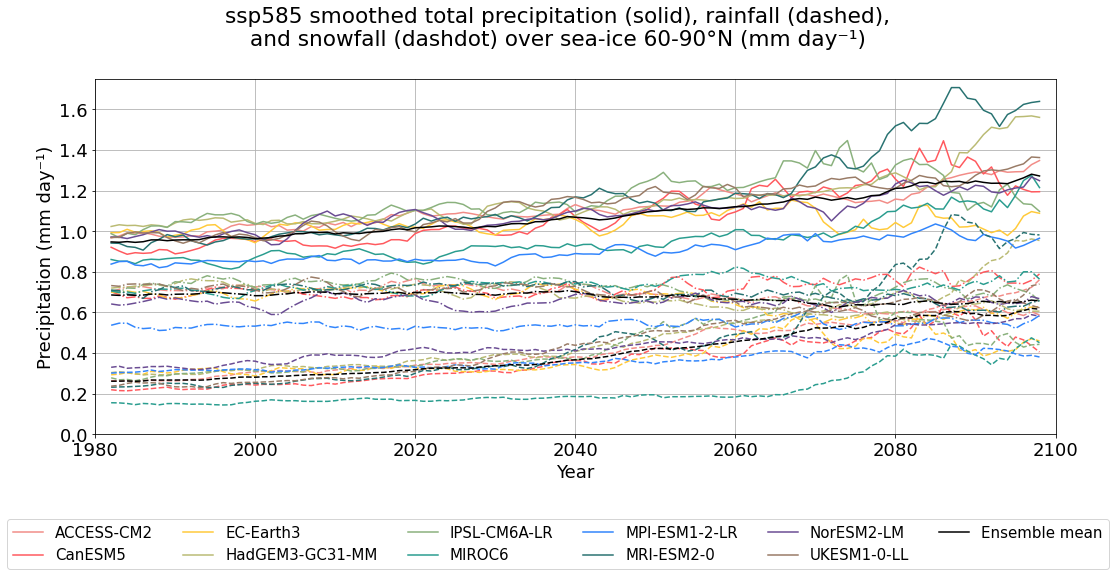

In [4]:
vars_series = [
    ensemble_pr_time_series,
    ensemble_prsn_time_series,
    ensemble_prra_time_series
]
plot_arr = []
for item in vars_series:
    item_processed = item.groupby('time.year').mean('time').rolling(year=5, center=True).mean('year')
    item_processed = libs.ensemble.calc_variable_mean(item_processed)
    plot_arr.append(item_processed)

plot_arr[1]['Ensemble mean'].attrs['plot_kwargs'] = { 'linestyle': 'dashdot' }
plot_arr[2]['Ensemble mean'].attrs['plot_kwargs'] = { 'linestyle': 'dashed' }

libs.plot.time_series_from_vars(
    plot_arr,
    title=f'{experiment} smoothed {time_series_text} 60-90°N ({time_series_units})',
    xattr='year',
    ylabel=time_series_y_label,
    yrange=time_series_y_range
);

In [5]:
import xarray

ensemble_siconc, weight_siconc = libs.ensemble.get_and_preprocess(
    'SImon', 
    experiment, 
    'siconc'
)

si_weighted_vars = ['pr', 'prsn', 'prra']
si_linestyles = ['solid', 'dashdot', 'dashed']
si_weighted_arr = []
for i, v in enumerate(si_weighted_vars):
    ensemble, weight = libs.ensemble.get_and_preprocess(
        component, 
        experiment, 
        v,
        preprocess=conf['preprocess']
    )
    
    data_vars = {}
    for item in ensemble:
        item_mask = [item_mask for item_mask in ensemble_siconc if item_mask['label'] == item['label']]
        if len(item_mask) == 0:
            continue

        item_mask = item_mask[0]['data']
        processed_data = time_series_process(item['data'])
        processed_data.attrs['color'] = item['color']
        processed_data = processed_data.drop_vars(['height', 'type'], errors='ignore')
        item_mask = item_mask.drop_vars(['height', 'type'], errors='ignore')

        item_weighted = (processed_data.where(item_mask > 15) * item_mask / 100).weighted(weight)
        item_reduced = getattr(
            item_weighted, 
            time_series_weighted_method
        )(dim=item_weighted.weights.dims, skipna=True)
        item_reduced.attrs['plot_kwargs'] = { 'linestyle': si_linestyles[i] }

        data_vars[item['label']] = item_reduced

    ds_si = xarray.Dataset(data_vars=data_vars)
    ds_si = libs.ensemble.calc_variable_mean(ds_si)
    ds_si['Ensemble mean'].attrs['plot_kwargs'] = { 'linestyle': si_linestyles[i] }
    si_weighted_arr.append(ds_si)

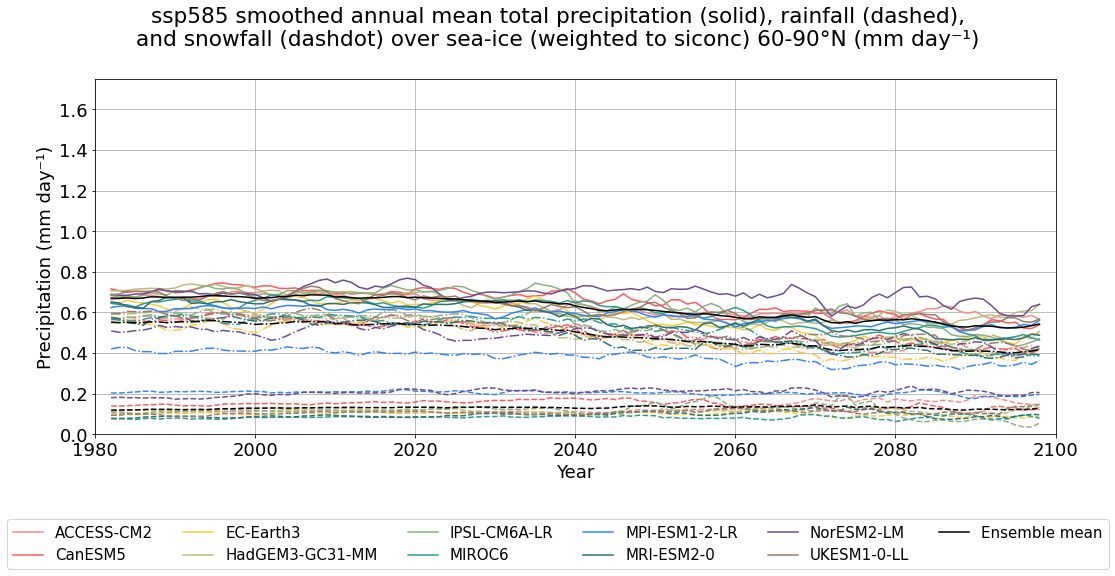

In [6]:
vars_series = si_weighted_arr
plot_arr = []
for item in vars_series:
    item_processed = item.groupby('time.year').mean('time').rolling(year=5, center=True).mean('year')
    item_processed = libs.ensemble.calc_variable_mean(item_processed)
    plot_arr.append(item_processed)

plot_arr[1]['Ensemble mean'].attrs['plot_kwargs'] = { 'linestyle': 'dashdot' }
plot_arr[2]['Ensemble mean'].attrs['plot_kwargs'] = { 'linestyle': 'dashed' }

libs.plot.time_series_from_vars(
    plot_arr,
    title=f'{experiment} smoothed annual mean {time_series_text} (weighted to siconc) 60-90°N ({time_series_units})',
    xattr='year',
    ylabel=time_series_y_label,
    yrange=time_series_y_range
);

## Monthly variability

### Full region (time)

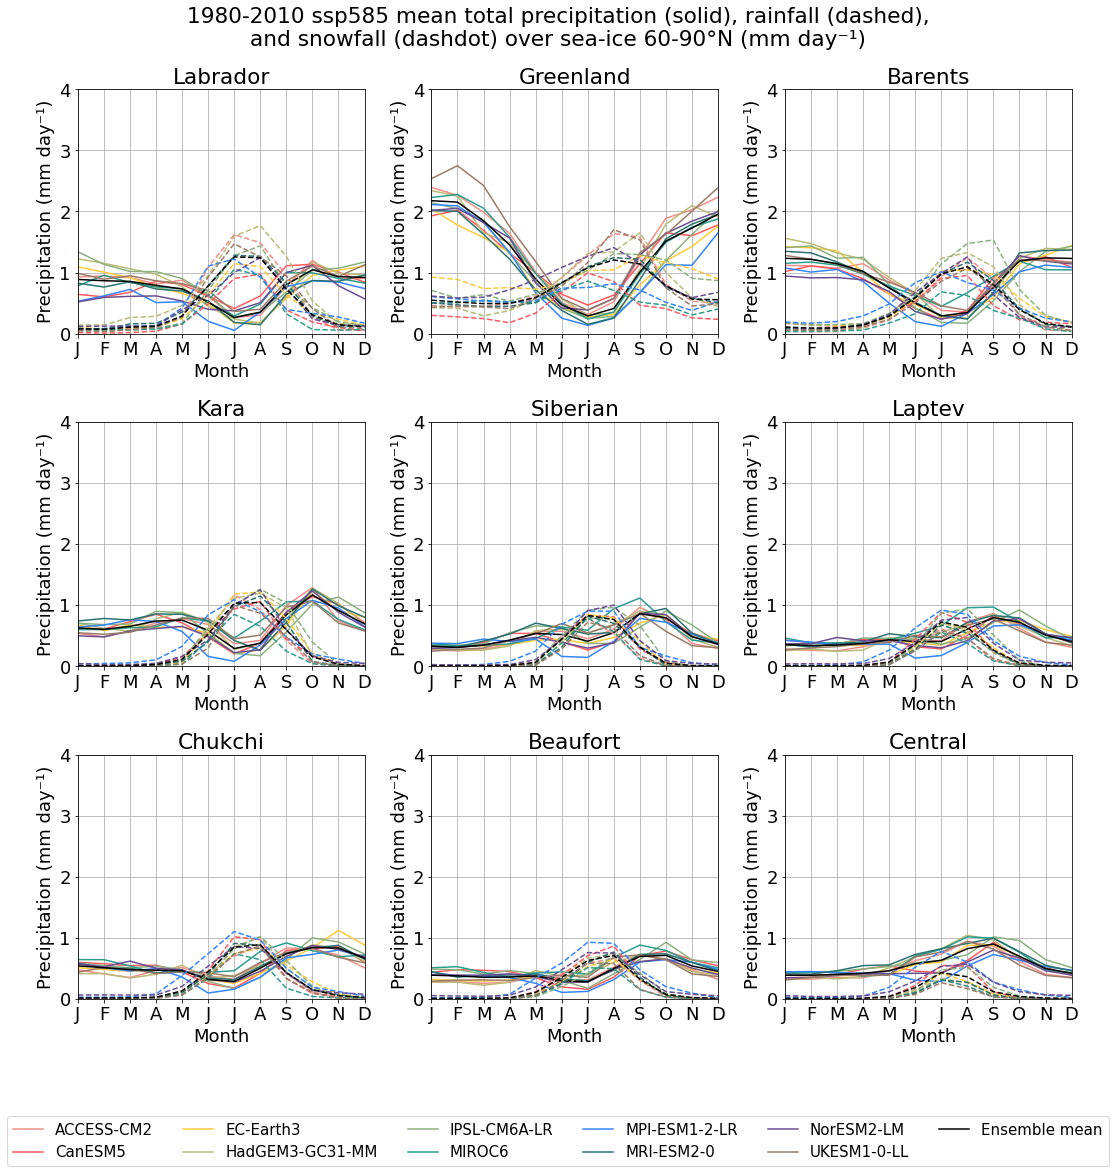

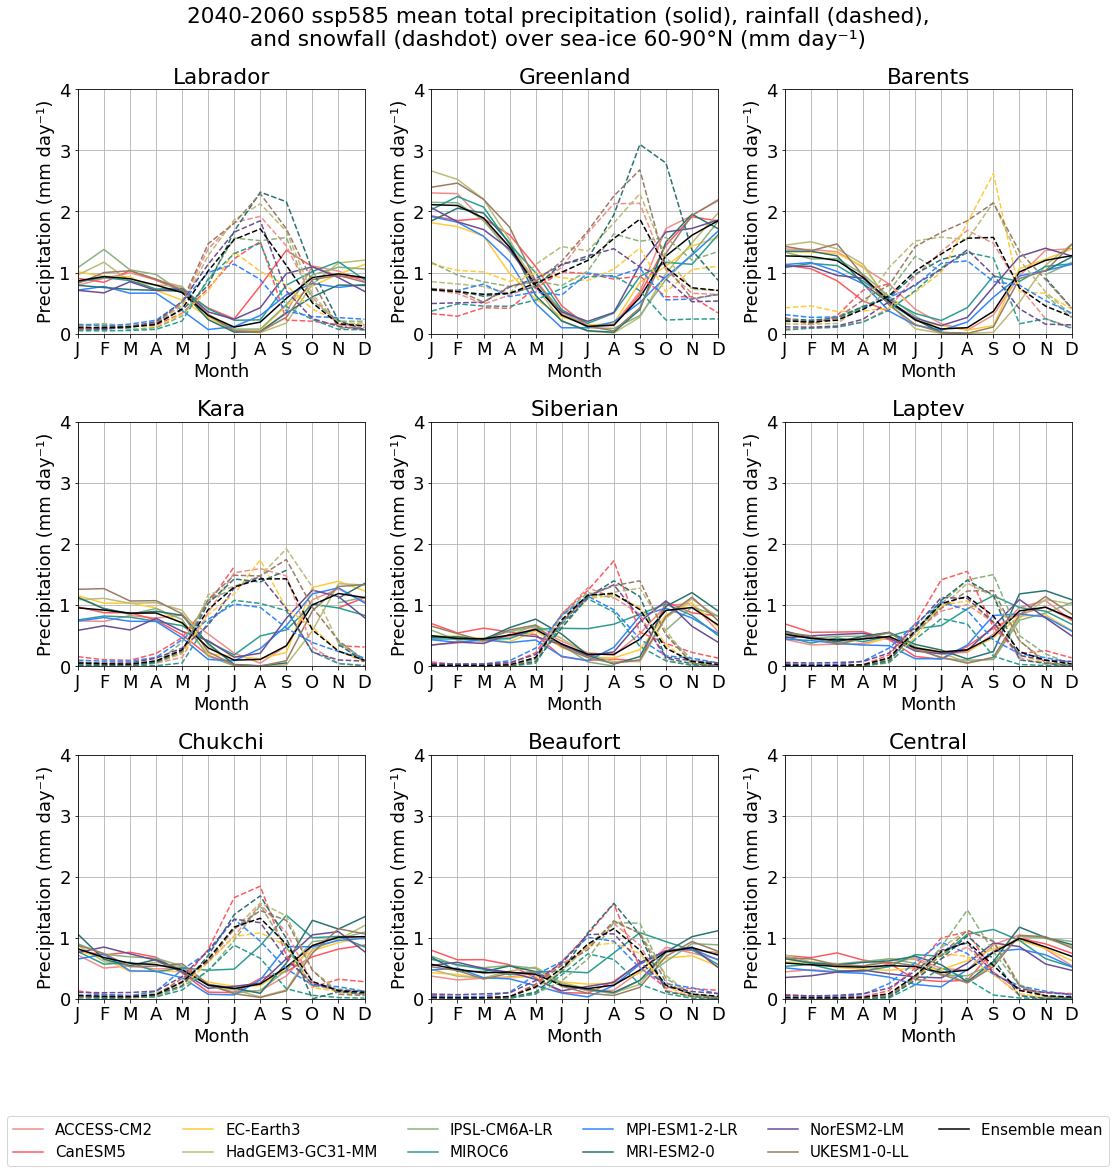

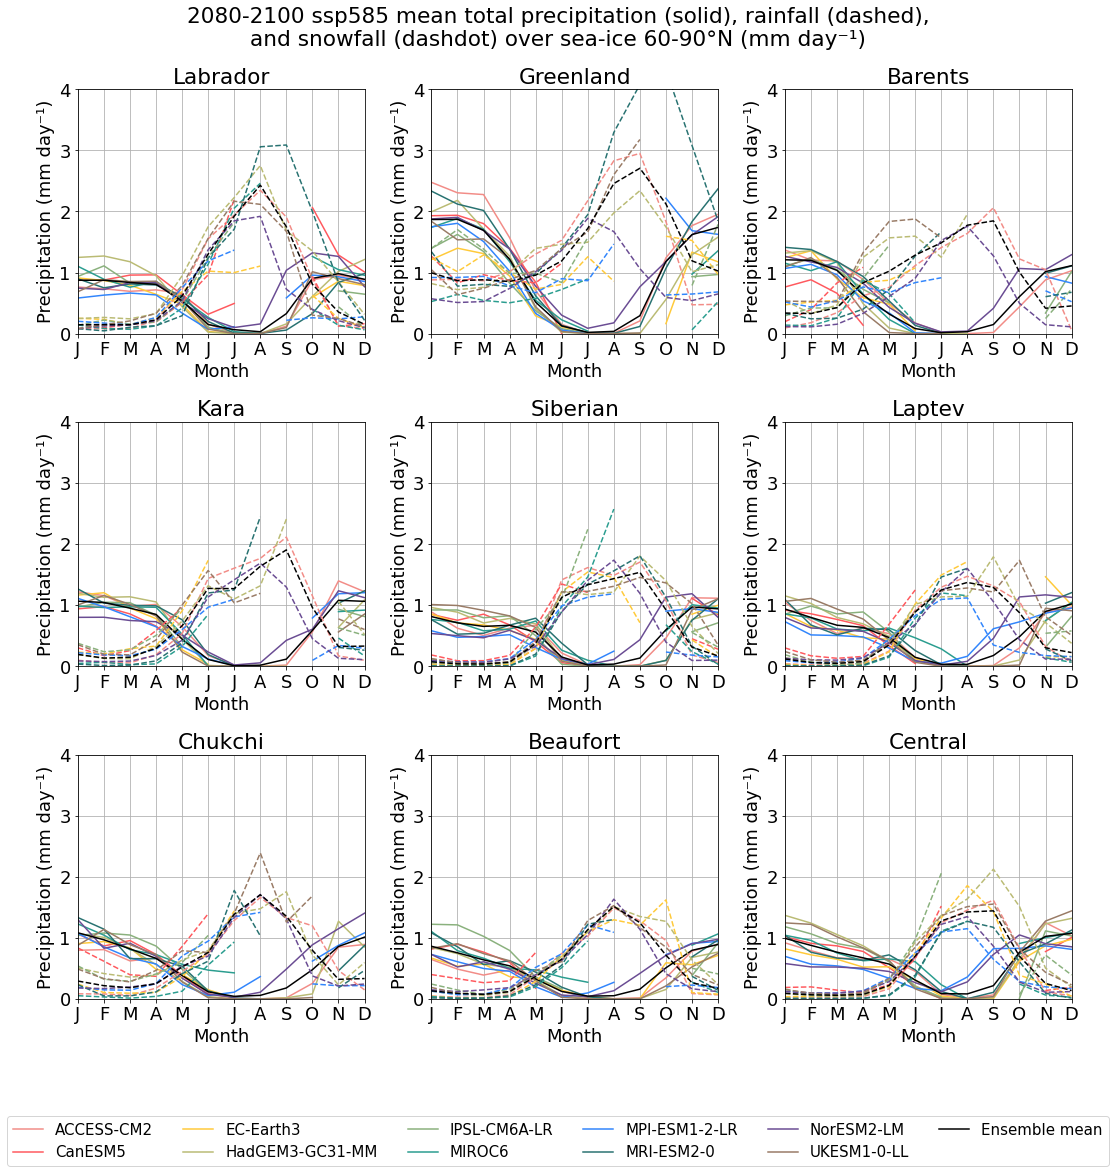

In [7]:
regions_prra = libs.local.get_ensemble_regional_series(variable_id, experiment)
regions_prsn = libs.local.get_ensemble_regional_series('prsn_siconc', experiment)

for s in time_slices:
    s_label = s['label']
    arr = []
    for i, data_prra in enumerate(regions_prra):   
        data_prra_slice = data_prra.sel(**s['slice']).groupby('time.month').mean('time')
        for variable in data_prra_slice:
            data_prra_slice[variable].attrs['plot_kwargs'] = { 'linestyle': 'dashed' }
        
        arr.append([
            regions_prsn[i].sel(**s['slice']).groupby('time.month').mean('time'),
            data_prra_slice,
        ])

    libs.plot.monthly_variability_regional(
        arr,
        title=f'{s_label} {experiment} mean {time_series_text} 60-90°N ({time_series_units})',
        ylabel=time_series_y_label,
        yrange=time_series_y_range_regional
    )

## Rain season length

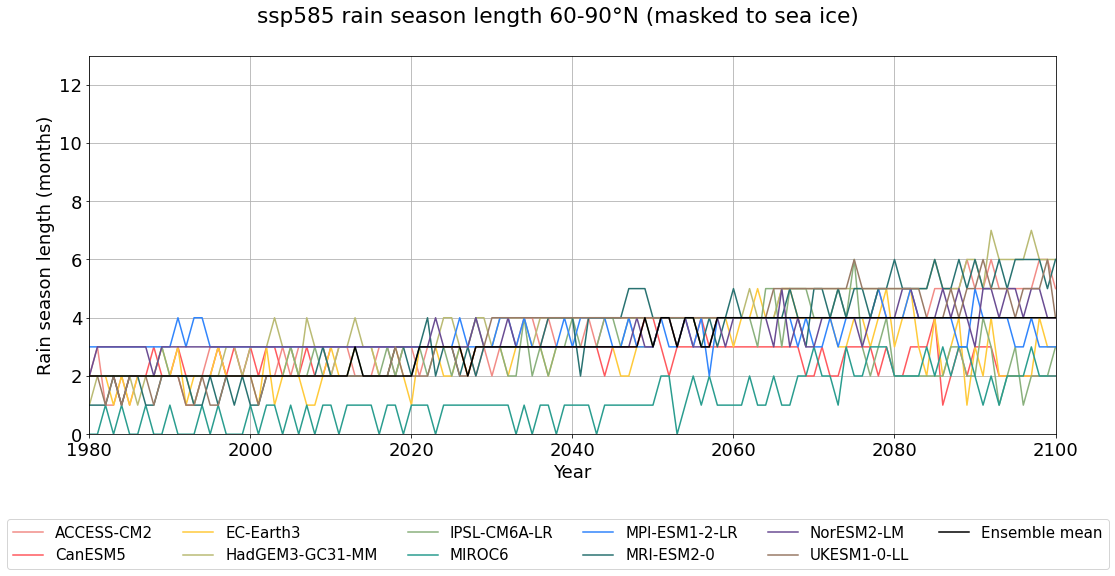

In [8]:
ensemble_rain_season_length = ensemble_pr_time_series.copy()
for key in ensemble_rain_season_length:
    ensemble_rain_season_length[key] = ensemble_rain_season_length[key]\
        .where(ensemble_prra_time_series[key] > ensemble_prsn_time_series[key])\
        .groupby('time.year')\
        .count('time')

ensemble_rain_season_length = libs.ensemble.calc_variable_mean(ensemble_rain_season_length, 'time')
ensemble_rain_season_length['Ensemble mean'] = ensemble_rain_season_length['Ensemble mean'].round()

fig = libs.plot.time_series_from_vars(
    [
        ensemble_rain_season_length
    ],
    title=f'{experiment} rain season length 60-90°N (masked to sea ice)',
    xattr='year',
    ylabel='Rain season length (months)',
    yrange=(0, 13)
);

#data = ensemble_rain_season_length
#data_min = data.to_array('time').min('time')
#data_max = data.to_array('time').max('time')

#fig.axes[0].fill_between(
#    data.year.values,
#    data_min.values,
#    data_max.values,
#    alpha=0.05,
#    color=data['Ensemble mean'].attrs['color'],
#    zorder=-1
#);

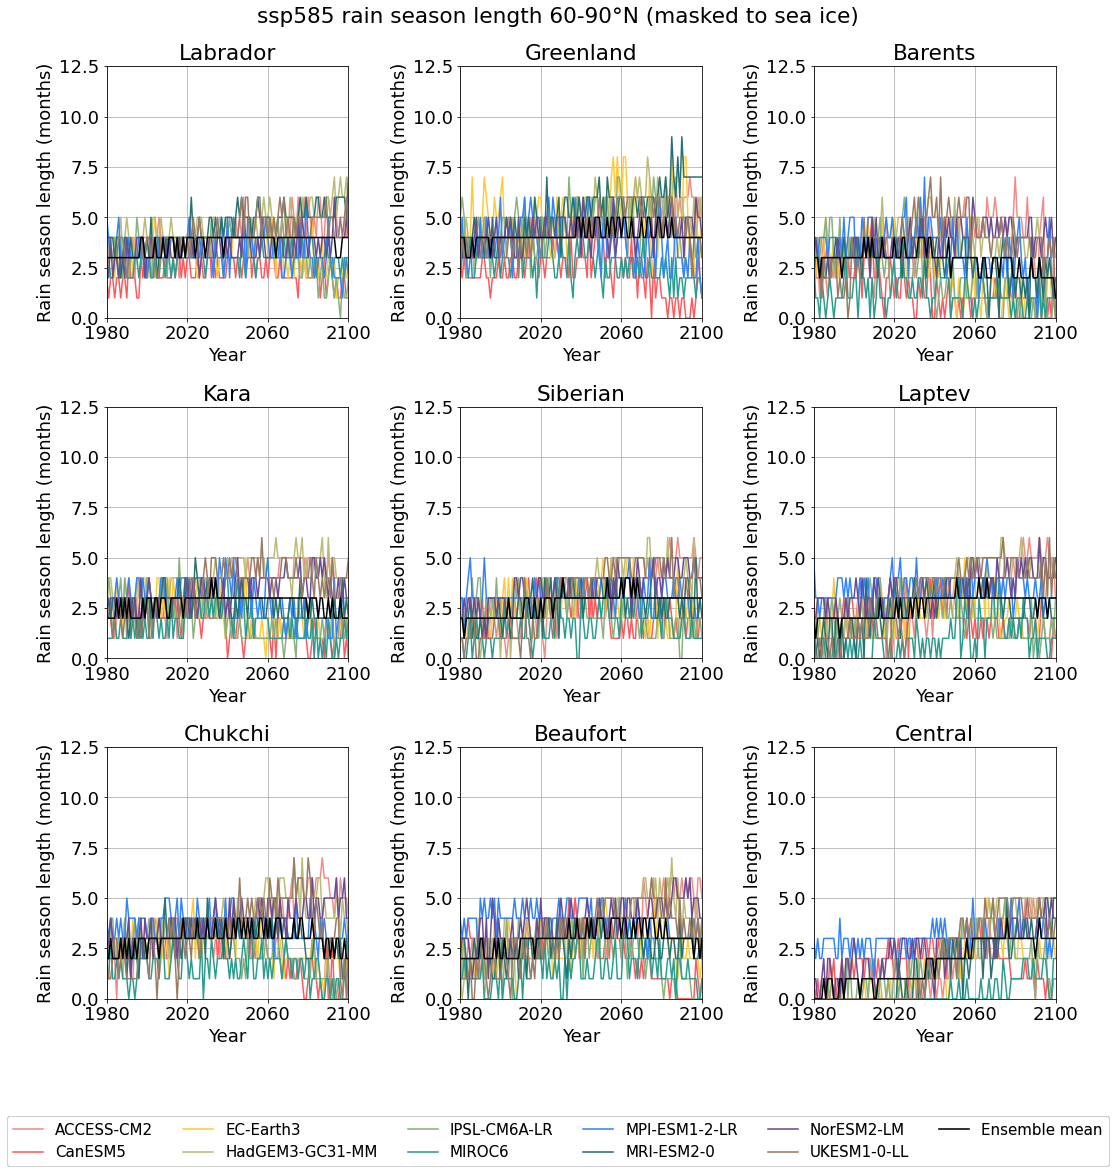

In [9]:
fig, axes = plt.subplots(*(3, 3), figsize=(15, 15))
axes = axes.flatten()
fig.suptitle(f'{experiment} rain season length 60-90°N (masked to sea ice)')

for i, data_prra in enumerate(regions_prra):
    ensemble_rain_season_length = data_prra.copy()
    data_prsn = regions_prsn[i]
    region = data_prra.attrs['region']

    for key in ensemble_rain_season_length:
        ensemble_rain_season_length[key] = ensemble_rain_season_length[key]\
            .where(data_prra[key] > data_prsn[key])\
            .groupby('time.year')\
            .count('time')

    ensemble_rain_season_length = libs.ensemble.calc_variable_mean(ensemble_rain_season_length, 'time')
    ensemble_rain_season_length['Ensemble mean'] = ensemble_rain_season_length['Ensemble mean'].round()
        
    fig = libs.plot.time_series_from_vars(
        [
            ensemble_rain_season_length
        ],
        ax=axes[i],
        fig=fig,
        xattr='year',
        ylabel='Rain season length (months)',
        yrange=(0, 12.5)
    )
    
    axes[i].set_title(region)
    axes[i].set_xticks([1980, 2020, 2060, 2100])